# **Portfolio Optimization using Deep Reinforcement Learning**


We analyzed the problem of Portfolio Optimization based on Reinforcement Learning (RL) framework. We defined our problem as: 

**Given histories of 4 different stocks, how could we train a policy to build a portfolio to maximize the likelihood of returns.**

Specifically, we trained a Deep Q-Learning framework with the following RL components:

*   **Environment:** The historical price data of the four selected stocks (JPMorgan, Citi, BoA, Wells Forgo)

*   **State:** The correlation matrix of the instruments in a specific time window. We chose it as the state variable because it reflects the relationships between different stocks, which is useful for portfolio allocation.

*   **Action:** Selecting and rebalancing the weights of each asset in portfolio. The Q-values generated by DQN Model will be converted into weights.

*   **Reward:** Sharpe Ratio (A measure of the excess return per unit of risk)

*   **Agent:** A portfolio manager who assigns a weight to each stock at each timestep based on the its observation.


In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random
import yfinance as yf

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2


import random
from collections import deque
import matplotlib.pylab as plt

## **1. Build the Environment**

In [2]:
class Environment:
    
    def __init__(self, start_date, end_date, capital = 1e6):   
        self.capital = capital 
        self.start_date = start_date
        self.end_date = end_date 
        self.data = self.load_data(self.start_date, self.end_date)

    def load_data(self, start_date, end_date):
        # Get the historical data of close prices from the start date to the end
        data = yf.download(tickers, start=start_date, end=end_date)['Close'][tickers]
        return data

    def preprocess_state(self, state):
        return state

    def get_state(self, t, lookback, is_cov_matrix = True, is_raw_time_series = False):

        assert lookback <= t

        decision_making_state = self.data.iloc[t-lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()

        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        else:
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback:t]
            return self.preprocess_state(decision_making_state)
        
    def get_reward(self, action, action_t, reward_t, alpha = 0.01):

        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean() 
            covs = returns.cov() 
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])

        data_period = self.data[action_t:reward_t]
        weights = action
        returns = data_period.pct_change().dropna()

        sharpe = local_portfolio(returns, weights)[-1]
        sharpe = np.array([sharpe] * len(self.data.columns))          
        rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]

        return np.dot(returns, weights), sharpe    

## **2.2 Create the Agent**

In [3]:
class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval
        
        # set hyper parameters
        self.alpha = 0.8
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        
        self.model = self._model()

    def _model(self):
        
        # DQN Model
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(200, activation='elu')(x)
        x = Dropout(0.65)(x) # dropout rate = 0.8
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.65)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else: # sell
                weights[e] = -np.abs(pred[e][0][r])

        #sum of absolute values in short is allowed
        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
        
    #return the action based on the state, uses the NN function 
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            #Reward =reward if not in the terminal state. 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

## **3. Model Training**

### **3.1. Parameter Settings**

In [55]:
N_ASSETS = 4
tickers = ['JPM', 'C', 'BAC', 'WFC']
window_size = 180
episode_count = 50
batch_size = 32
rebalance_period = 90 #every 90 days weight change

### **3.2. Initialize the agent and environment**

In [56]:
agent = Agent(N_ASSETS)
env = Environment(start_date='2015-01-01', end_date = '2017-12-31') 
env_test = Environment(start_date='2018-01-01', end_date = '2019-01-01')

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


In [57]:
env.data

,JPM,C,BAC,WFC
Date,,,,
2015-01-02,62.490002,54.259998,17.900000,54.700001
2015-01-05,60.549999,52.549999,17.379999,53.200001
2015-01-06,58.980000,50.700001,16.860001,52.090000
2015-01-07,59.070000,51.169998,16.940001,52.400002
2015-01-08,60.389999,51.939999,17.290001,53.560001
...,...,...,...,...
2017-12-22,107.449997,75.489998,29.879999,61.549999
2017-12-26,107.019997,74.779999,29.780001,61.130001
2017-12-27,107.220001,74.889999,29.730000,60.950001


In [58]:
env_test.data

,JPM,C,BAC,WFC
Date,,,,
2018-01-02,107.949997,74.360001,29.900000,61.090000
2018-01-03,108.059998,74.589996,29.799999,61.560001
2018-01-04,109.040001,75.510002,30.190001,62.330002
2018-01-05,108.339996,75.410004,30.330000,62.750000
2018-01-08,108.500000,74.529999,30.120001,62.040001
...,...,...,...,...
2018-12-24,92.139999,49.259998,22.730000,43.599998
2018-12-26,95.959999,51.439999,24.110001,45.590000
2018-12-27,97.040001,51.770000,24.370001,45.529999


### **3.3. Model Training**

In [59]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(env.data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):
        date1 = t-rebalance_period
        #correlation from 90-180 days 
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])
        
        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    # Plot the training result for each episode
    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()
    

Output hidden; open in https://colab.research.google.com to view.

### **3.3. Experiments**
We test our model based on the historical stock market in the whole year of 2018. 5 seeds are calculated and the average return at each step will be considered a performance evaluation metric.

In [62]:
def test_agent(seed):
   agent.is_eval = True # performance 
   
   window_size=90
   data_length = len(env_test.data)

   returns_history = []
   returns_history_equal = []

   rewards_history = []
   equal_rewards = []
    
   actions_to_show = []
   s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
   total_profit = 0 

   for t in range(window_size, len(env_test.data), rebalance_period):
        date1 = t-rebalance_period
        #correlation from 90-180 days 
        s_ = env_test.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])
        
        weighted_returns, reward = env_test.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env_test.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

   return returns_history, returns_history_equal

In [63]:
# Loop over 5 different seeds and store performance metrics in a list
seeds = [1, 2, 3, 4, 5]
result_rls = []
result_equals = []

for seed in seeds:
    result_rl, result_equal  = test_agent(seed)

    #result_equal = [item for sublist in result_equal for item in sublist]
    #result_rl = [item for sublist in result_rl for item in sublist]

    result_rl = np.array(result_rl).cumsum()
    result_equal = np.array(result_equal).cumsum()

    result_rl = result_rl.tolist()
    result_equal = result_equal.tolist()

    result_rls.append(result_rl)
    result_equals.append(result_equal)

#print(result_rls)
#print(result_equals)

# Calculate average or median performance metric
avg_rl = np.mean(result_rls,axis=0)
#print(avg_rl)
std_rl = np.std(result_rls,axis=0)
median_rl = np.median(result_rls,axis=0)

avg_equal = np.mean(result_equals,axis=0)
std_equal = np.std(result_equals,axis=0)
median_equal = np.median(result_equals,axis=0)

#print(avg_equal)

1/1 [==============================] - 0s 24ms/step


In [64]:
import datetime

start_date = datetime.datetime(2018, 1, 1)  # Define the start date
end_date = datetime.datetime(2018, 12, 31)  # Define the end date
num_days = (end_date - start_date).days + 1  # Calculate the number of days between the start and end dates
delta =  num_days/len(avg_rl)
timesteps = range(0, num_days-10, 2)  # Define the x-axis values as the number of days

# Convert the timesteps to dates
dates = [start_date + datetime.timedelta(days=x) for x in timesteps]

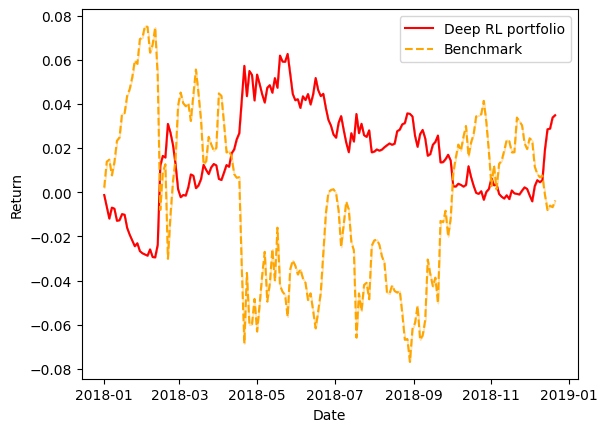

In [65]:
# Plot the figure
fig, ax = plt.subplots()
ax.plot(dates, avg_rl, label='Deep RL portfolio', color='red', ls='-')
ax.fill_between(dates, avg_rl - std_rl, avg_rl + std_rl, color='red', alpha=0.3)
ax.plot(dates, avg_equal, label='Benchmark', color='orange', ls='--')
ax.fill_between(dates, avg_equal - std_equal, avg_equal + std_equal, color='orange', alpha=0.3)

ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Return')
plt.show()

In [66]:
avg_rl[-1]

0.034901630812468644

In [67]:
avg_equal[-1]

-0.0037396647823090268